In [1]:
from pathlib import Path

import matplotlib.pyplot as plt
import pandas as pd
import pyarrow as pa
from pyarrow.parquet import ParquetFile, ParquetWriter

import numpy as np
import gc
from numpy.typing import NDArray
import numba
import math

try:
	from tqdm.notebook import tqdm	# prettier in Jupyter
except Exception:
	from tqdm.auto import tqdm		# fallback


from IPython.core.interactiveshell import InteractiveShell


from tpx3awkward._utils import (
    drop_zero_tot,
    cluster_df_optimized,
    group_indices,
    centroid_clusters,
    ingest_cent_data,
    add_centroid_cols,
    trim_corr_file,
    trim_corr,
    timewalk_corr,
    DEFAULT_CLUSTER_TW,
    DEFAULT_CLUSTER_RADIUS,
    raw_as_numpy,
	 ingest_raw_data,
	is_packet_header,
        matches_nibble,
        get_block,
		  decode_message,
)


InteractiveShell.ast_node_interactivity = "all"  # ustaw raz w notatniku

In [2]:
DEFAULT_CLUSTER_RADIUS = 3
DEFAULT_CLUSTER_TW =  int(0.3e-6 / 1.5625e-9)  # reuse your constant
DEFAULT_CLUSTER_TW

@numba.njit(cache=True)
def cluster_events(events: np.ndarray, radius: int, tw: int):
    # events: (N,4) -> x,y,ToT,t
    n = events.shape[0]
    labels = np.full(n, -1, np.int64)
    cluster_id = 0
    r2 = radius * radius
    for i in range(n):
        if labels[i] != -1:
            continue
        labels[i] = cluster_id
        t_i = events[i, 3]
        x_i = events[i, 0]
        y_i = events[i, 1]
        for j in range(i + 1, n):
            # early exit on time window
            if events[j, 3] - t_i > tw:
                break
            dx = x_i - events[j, 0]
            dy = y_i - events[j, 1]
            if dx*dx + dy*dy <= r2:
                labels[j] = cluster_id
        cluster_id += 1
    return labels

def cluster_df_corrected(df: pd.DataFrame, tw=DEFAULT_CLUSTER_TW, radius=DEFAULT_CLUSTER_RADIUS):
    df_sorted = df.sort_values("t", kind="mergesort").reset_index(drop=True)
    events = df_sorted[["x","y","ToT","t"]].to_numpy()
    labels = cluster_events(events, radius, tw)
    return labels, events

@numba.njit(cache=True)
def group_indices(labels: np.ndarray):
    n_clusters = labels.max() + 1
    counts = np.zeros(n_clusters, np.int32)
    for lab in labels:
        counts[lab] += 1
    max_size = counts.max()
    out = -1 * np.ones((n_clusters, max_size), dtype=np.int32)
    fill = np.zeros(n_clusters, np.int32)
    for i in range(labels.size):
        c = labels[i]
        pos = fill[c]
        out[c, pos] = i
        fill[c] += 1
    return out

@numba.njit(cache=True)
def centroid_clusters(cluster_arr: np.ndarray, events: np.ndarray):
    n_clusters = cluster_arr.shape[0]
    max_cluster = cluster_arr.shape[1]
    t = np.zeros(n_clusters, dtype=np.uint64)
    xc = np.zeros(n_clusters, dtype=np.float32)
    yc = np.zeros(n_clusters, dtype=np.float32)
    ToT_max = np.zeros(n_clusters, dtype=np.uint32)
    ToT_sum = np.zeros(n_clusters, dtype=np.uint32)
    n = np.zeros(n_clusters, dtype=np.uint8)
    for cid in range(n_clusters):
        local_max = np.uint32(0)
        for k in range(max_cluster):
            ei = cluster_arr[cid, k]
            if ei < 0:
                break
            x = events[ei,0]
            y = events[ei,1]
            tot = np.uint32(events[ei,2])
            ts = events[ei,3]
            if tot > local_max:
                local_max = tot
                ToT_max[cid] = tot
                t[cid] = ts
            xc[cid] += x * tot
            yc[cid] += y * tot
            ToT_sum[cid] += tot
            n[cid] += 1
        if ToT_sum[cid] > 0:
            xc[cid] /= ToT_sum[cid]
            yc[cid] /= ToT_sum[cid]
    return t, xc, yc, ToT_max, ToT_sum, n

def add_centroid_cols(df: pd.DataFrame, gap=False):
    if gap:
        df.loc[df["xc"] >= 255.5, "xc"] += 2
        df.loc[df["yc"] >= 255.5, "yc"] += 2
    df["x"] = np.round(df["xc"]).astype(np.uint16)
    df["y"] = np.round(df["yc"]).astype(np.uint16)
    df["t_ns"] = df["t"].astype(np.float64) * 1.5625
    return df

192

In [3]:
def read_uint64_chunks(fpath, chunk_words=5_000_000):
    fpath = Path(fpath)
    with fpath.open("rb") as fh:
        while True:
            arr = np.fromfile(fh, dtype="<u8", count=chunk_words)
            if arr.size == 0:
                break
            yield arr

class StreamingDecoder:
    def __init__(self):
        self.heartbeat_lsb = None
        self.heartbeat_msb = None
        self.heartbeat_time = np.uint64(0)
        self.hb_init_flag = False
        self.chip_indx = np.uint8(0)

    def process_chunk(self, words: np.ndarray):
        photons = []
        for msg in words:
            if is_packet_header(msg):
                self.chip_indx = np.uint8(get_block(msg, 8, 32))
            elif matches_nibble(msg, 0xB):
                x,y,ToT,t = decode_message(msg, self.chip_indx, heartbeat_time=self.heartbeat_time)
                photons.append((t,x,y,ToT,self.chip_indx))
            elif matches_nibble(msg, 0x4):
                sub = (msg >> np.uint64(56)) & np.uint64(0x0F)
                if sub == 0x4:
                    self.heartbeat_lsb = (msg >> np.uint64(16)) & np.uint64(0xFFFFFFFF)
                elif sub == 0x5 and self.heartbeat_lsb is not None:
                    self.heartbeat_msb = ((msg >> np.uint64(16)) & np.uint64(0xFFFF)) << np.uint64(32)
                    self.heartbeat_time = self.heartbeat_msb | self.heartbeat_lsb
        return photons

def flush_cluster_centroid(df_raw_batch, tw=DEFAULT_CLUSTER_TW, radius=DEFAULT_CLUSTER_RADIUS, gap_corr=False):
    if df_raw_batch.empty:
        # Return empty raw and centroid dfs
        return df_raw_batch, pd.DataFrame(columns=["t","xc","yc","ToT_max","ToT_sum","n"])
    df = drop_zero_tot(df_raw_batch)
    labels, events = cluster_df_optimized(df, tw=tw, radius=radius)
    df["cluster_id"] = labels
    cluster_array = group_indices(labels)
    cent_tuple = centroid_clusters(cluster_array, events)
    cent_df = pd.DataFrame(ingest_cent_data(cent_tuple)).sort_values("t").reset_index(drop=True)
    cent_df = add_centroid_cols(cent_df, gap=gap_corr)  # was gap=True
    return df, cent_df

def stream_process_file(
    fpath,
    out_raw="raw_big.parquet",
    out_cent="cent_big.parquet",
    chunk_words=5_000_000,
    flush_after=2_500_000,
    overlap_ticks=300_000,
    tw=DEFAULT_CLUSTER_TW,
    radius=DEFAULT_CLUSTER_RADIUS,
    gap_corr=False,  # new parameter
):
    """
    Streaming decode + clustering with incremental (append) parquet writes.
    Fixes previous behavior that overwrote the parquet at every flush.
    """
    raw_out = Path(out_raw)
    cent_out = Path(out_cent)

    # Start clean
    if raw_out.exists():
        raw_out.unlink()
    if cent_out.exists():
        cent_out.unlink()

    decoder = StreamingDecoder()
    buffer = []
    max_t = 0

    # For incremental parquet writing
    raw_writer = None
    cent_writer = None

    fsize = Path(fpath).stat().st_size
    est_chunks = math.ceil(fsize / (chunk_words * 8)) or None

    photons_total = 0
    pbar = tqdm(
        read_uint64_chunks(fpath, chunk_words=chunk_words),
        total=est_chunks,
        desc="Streaming decode",
        unit="chunk"
    )

    def write_batch(raw_df: pd.DataFrame, cent_df: pd.DataFrame):
        nonlocal raw_writer, cent_writer
        # Convert once per batch
        raw_table = pa.Table.from_pandas(raw_df, preserve_index=False)
        cent_table = pa.Table.from_pandas(cent_df, preserve_index=False)
        if raw_writer is None:
            raw_writer = ParquetWriter(str(raw_out), raw_table.schema, compression="zstd")
        if cent_writer is None:
            cent_writer = ParquetWriter(str(cent_out), cent_table.schema, compression="zstd")
        raw_writer.write_table(raw_table)
        cent_writer.write_table(cent_table)

    for chunk in pbar:
        photons = decoder.process_chunk(chunk)
        if photons:
            buffer.extend(photons)
            photons_total += len(photons)
            mt = max(p[0] for p in photons)
            if mt > max_t:
                max_t = mt

        pbar.set_postfix({"photons": photons_total, "buffer": len(buffer)})

        if len(buffer) >= flush_after:
            buffer.sort(key=lambda r: r[0])
            cutoff = max_t - overlap_ticks
            flush_part = [p for p in buffer if p[0] <= cutoff]
            buffer = [p for p in buffer if p[0] > cutoff]

            if flush_part:
                df_flush = pd.DataFrame(flush_part, columns=["t","x","y","ToT","chip"])
                raw_df, cent_df = flush_cluster_centroid(df_flush, tw=tw, radius=radius, gap_corr=gap_corr)
                write_batch(raw_df, cent_df)
                del raw_df, cent_df, df_flush, flush_part
                gc.collect()

    # Final flush
    if buffer:
        buffer.sort(key=lambda r: r[0])
        df_final = pd.DataFrame(buffer, columns=["t","x","y","ToT","chip"])
        raw_df, cent_df = flush_cluster_centroid(df_final, tw=tw, radius=radius, gap_corr=gap_corr)
    else:
        raw_df = pd.DataFrame(columns=["t","x","y","ToT","chip","cluster_id"])
        cent_df = pd.DataFrame(columns=["t","xc","yc","ToT_max","ToT_sum","n","x","y","t_ns"])

    write_batch(raw_df, cent_df)

    # Close writers
    if raw_writer is not None:
        raw_writer.close()
    if cent_writer is not None:
        cent_writer.close()

    return raw_out, cent_out


In [4]:
# data_dir = Path('/home/hades/projects/TimeVaryingDiffuser/Experiment_controll/data_timepix/Measurement_Nov_21_2025_16h20m39s/raw')
# filename_sufix = 'fGKd_000000'

#data_dir, filename_sufix="Measurement_Nov_21_2025_16h20m39s","fGKd_000000" #noscatterr
data_dir, filename_sufix="Measurement_Nov_21_2025_16h23m49s","fGNn_000000" # dynamic
#data_dir, filename_sufix="Measurement_Nov_21_2025_16h31m33s","fGVX_000000" # static

data_dir_path=Path(f'/home/hades/projects/TimeVaryingDiffuser/Experiment_controll/data_timepix/{data_dir}/raw')
fpath = data_dir_path / f'{filename_sufix}.tpx3'

In [5]:
# Run
out_dir= Path('out')
out_dir.mkdir(exist_ok=True, parents=True)
raw_out_path=out_dir / f"{data_dir}_raw_big.parquet"
cent_out_path=out_dir / f"{data_dir}_cent_big.parquet"


In [6]:



raw_path, cent_path = stream_process_file(
    fpath=fpath,
    out_raw=raw_out_path,
    out_cent=cent_out_path,
    chunk_words=3_000_000,
    flush_after=1_000_000,
    overlap_ticks=300_000,
    tw=DEFAULT_CLUSTER_TW,
    radius=DEFAULT_CLUSTER_RADIUS,
    gap_corr=False,  # disable +2 shift
)
print("Raw exists:", raw_path.exists(), "Cent exists:", cent_path.exists())
print("Absolute raw:", raw_path.resolve())
print("Absolute cent:", cent_path.resolve())

Streaming decode:   0%|          | 0/196 [00:00<?, ?chunk/s]

KeyboardInterrupt: 

In [9]:
def load_parquet_range(path: str | Path,
                       i_min: int | None = None,
                       i_max: int | None = None,
                       columns: list[str] | None = None) -> pd.DataFrame:
    """
    Load a row slice [i_min, i_max) from a parquet file without reading all data.
    If i_min or i_max is None, the whole file (optionally restricted to `columns`) is loaded.

    Parameters
    ----------
    path : str | Path
        Parquet file path.
    i_min : int | None
        Start row (inclusive). None -> full file.
    i_max : int | None
        End row (exclusive). None -> full file.
    columns : list[str] | None
        Column subset to read. None -> all columns.

    Returns
    -------
    pd.DataFrame
    """
    pf = ParquetFile(str(path))

    # Full read path
    if i_min is None or i_max is None:
        # Efficient full read (optionally select columns)
        tables = []
        for rg in range(pf.num_row_groups):
            tables.append(pf.read_row_group(rg, columns=columns))
        if not tables:
            return pd.DataFrame()
        return pa.concat_tables(tables).to_pandas()

    if i_min >= i_max or i_max <= 0:
        return pd.DataFrame()

    out = []
    offset = 0
    for rg in range(pf.num_row_groups):
        n_rows = pf.metadata.row_group(rg).num_rows
        rg_start = offset
        rg_end = offset + n_rows

        if rg_end <= i_min:          # row group before range
            offset = rg_end
            continue
        if rg_start >= i_max:        # past requested range
            break

        inner_start = max(0, i_min - rg_start)
        inner_end = min(n_rows, i_max - rg_start)

        table = pf.read_row_group(rg, columns=columns)
        if inner_start != 0 or inner_end != n_rows:
            table = table.slice(inner_start, inner_end - inner_start)
        out.append(table)
        offset = rg_end

    if not out:
        return pd.DataFrame()

    return pa.concat_tables(out).to_pandas()




In [8]:
# raw_big = load_parquet_range(path=raw_out_path)
# raw_big['x']=raw_big['x']-256
# raw_big.sort_values('t')

,t,x,y,ToT,chip,cluster_id
0,441928,106,130,300,0,0
1,441936,123,129,150,0,1
2,442178,170,98,1500,0,2
3,442178,171,99,1750,0,2
4,442178,171,98,2325,0,2
...,...,...,...,...,...,...
26562058,6399160513,123,127,25,0,250
26562059,6399161413,150,59,350,0,252
26562060,6399161421,151,59,300,0,252
26562061,6399161426,150,60,300,0,252


In [9]:
# raw_big['y'].describe()

,t,x,y,ToT,chip,cluster_id
0,441928,106,130,300,0,0
1,441936,123,129,150,0,1
2,442178,170,98,1500,0,2
3,442178,171,99,1750,0,2
4,442178,171,98,2325,0,2
...,...,...,...,...,...,...
26562058,6399160513,123,127,25,0,250
26562059,6399161413,150,59,350,0,252
26562060,6399161421,151,59,300,0,252
26562061,6399161426,150,60,300,0,252


In [28]:
# i_min=0
# i_max=10**5
#
# raw_subset = load_parquet_range(path=raw_out_path,i_min=i_min, i_max=i_max)
# cent_subset = load_parquet_range(path=cent_out_path,i_min=i_min, i_max=i_max)
# print(raw_subset.shape, cent_subset.shape)
# raw_subset



count    1351.000000
mean      117.968912
std        39.807302
min         2.000000
25%       116.000000
50%       125.000000
75%       132.000000
max       242.000000
Name: y, dtype: float64

In [10]:
cent_big = load_parquet_range(path=cent_out_path)
cent_big['x']=cent_big['x']-256
cent_big['xc']=cent_big['xc']-256
cent_big=cent_big.sort_values('t')

In [10]:
cent_big.info()

<class 'pandas.core.frame.DataFrame'>
Index: 105464390 entries, 84739299 to 105464389
Data columns (total 9 columns):
 #   Column   Dtype  
---  ------   -----  
 0   t        uint64 
 1   xc       float32
 2   yc       float32
 3   ToT_max  uint32 
 4   ToT_sum  uint32 
 5   n        uint8  
 6   x        uint16 
 7   y        uint16 
 8   t_ns     float64
dtypes: float32(2), float64(1), uint16(2), uint32(2), uint64(1), uint8(1)
memory usage: 4.4 GB


In [ ]:
#cent_big.describe()

In [14]:
def make_scaled_canvas(scale: int, dtype=np.uint32):
    """
    Allocate a blank canvas for a scaled 256x256 sensor.
    Final shape: (256*scale, 256*scale)
    """
    if scale < 1:
        raise ValueError("scale must be >= 1")
    size = 256 * scale
    return np.zeros((size, size), dtype=dtype)

def centroid_to_canvas(
    df: pd.DataFrame,
    scale: int = 1,
    x_col: str = "xc",
    y_col: str = "yc",
    weight: str = "count",
    canvas: np.ndarray | None = None,
    offset_x: float = 0.0,
    offset_y: float = 0.0,
):
    """
    Project centroid rows onto a scaled pixel canvas using mathematical rounding.

    Parameters
    ----------
    df : pd.DataFrame       DataFrame with centroid columns.
    scale : int             Linear scale factor (1 -> 256x256, 2 -> 512x512, ...).
    x_col, y_col : str      Columns holding centroid coordinates (float).
    weight : str            'count' -> increment per centroid, or name of a numeric column (e.g. 'ToT_sum').
    canvas : np.ndarray     Optional preallocated target. If None, a new one is made.
    offset_x, offset_y : float  Shifts applied before rounding/scaling.

    Returns
    -------
    np.ndarray
        Accumulated canvas.
    """
    if canvas is None:
        canvas = make_scaled_canvas(scale)
    size = 256 * scale

    # Extract coordinates
    x = df[x_col].to_numpy(dtype=np.float64)
    y = df[y_col].to_numpy(dtype=np.float64)

    # Apply scaling and rounding (mathematical: round half away from zero via np.rint)
    x_pix = np.rint((x + offset_x) * scale).astype(np.int64)
    y_pix = np.rint((y + offset_y) * scale).astype(np.int64)

    # Bounds mask
    m = (x_pix >= 0) & (x_pix < size) & (y_pix >= 0) & (y_pix < size)
    if not np.any(m):
        return canvas

    if weight == "count":
        vals = np.ones(m.sum(), dtype=canvas.dtype)
    else:
        if weight not in df.columns:
            raise ValueError(f"weight column '{weight}' not in DataFrame")
        vals = df.loc[m, weight].to_numpy()
        # Cast / sanitize
        if not np.issubdtype(vals.dtype, np.number):
            raise TypeError(f"weight column '{weight}' must be numeric")
        if canvas.dtype != vals.dtype:
            vals = vals.astype(canvas.dtype, copy=False)

    # Accumulate (y first because row-major)
    np.add.at(canvas, (y_pix[m], x_pix[m]), vals)
    return canvas

def build_scaled_canvases(
    df: pd.DataFrame,
    scales: list[int],
    weight: str = "count",
    x_col: str = "xc",
    y_col: str = "yc",
    offset_x: float = 0.0,
    offset_y: float = 0.0,
):
    """
    Convenience: build multiple scaled canvases.
    Returns dict scale -> canvas.
    """
    out = {}
    for s in scales:
        c = make_scaled_canvas(s)
        centroid_to_canvas(
            df=df,
            scale=s,
            x_col=x_col,
            y_col=y_col,
            weight=weight,
            canvas=c,
            offset_x=offset_x,
            offset_y=offset_y,
        )
        out[s] = c
    return out

# Example usage after cent_big is prepared:
# (Assumes cent_big['xc'], cent_big['yc'] already shifted if needed)
# canvases = build_scaled_canvases(cent_big, scales=[1,2,3], weight="ToT_sum")
# plt.figure(figsize=(6,6)); plt.imshow(canvases[1], origin="lower"); plt.title("Scale 1 ToT_sum")
# plt.figure(figsize=(6,6)); plt.imshow(canvases[2], origin="lower"); plt.title("Scale 2 ToT_sum")
# plt.figure(figsize=(6,6)); plt.imshow(canvases[3], origin="lower"); plt.title("Scale 3 ToT_sum")

# After cent_big loaded:
# scale1_canvas = centroid_to_canvas(cent_big, scale=1, weight="count")
# scale2_canvas = centroid_to_canvas(cent_big, scale=2, weight="ToT_sum")
# scale3_canvas = centroid_to_canvas(cent_big, scale=3, weight="ToT_max")
# plt.figure(); plt.imshow(scale2_canvas, origin="lower"); plt.title("Scale 2 ToT_sum")


In [ ]:
cent_big['1']=1

In [ ]:
scale1_canvas_1 = centroid_to_canvas(cent_big, scale=1, weight="1")
scale1_canvas_ToT_max = centroid_to_canvas(cent_big, scale=1, weight="ToT_max")
scale1_canvas_ToT_sum = centroid_to_canvas(cent_big, scale=1, weight="ToT_sum")

<Figure size 640x480 with 0 Axes>

Text(0.5, 1.0, 'Scale 1 count 1')

<Figure size 640x480 with 0 Axes>

Text(0.5, 1.0, 'Scale 1 ToT_max')

<Figure size 640x480 with 0 Axes>

Text(0.5, 1.0, 'Scale 1 ToT_sum')

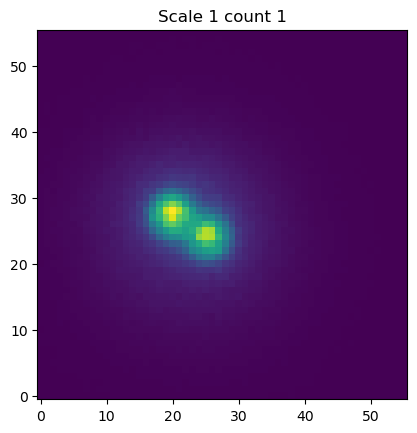

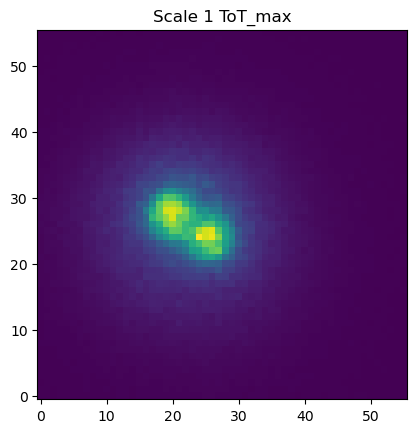

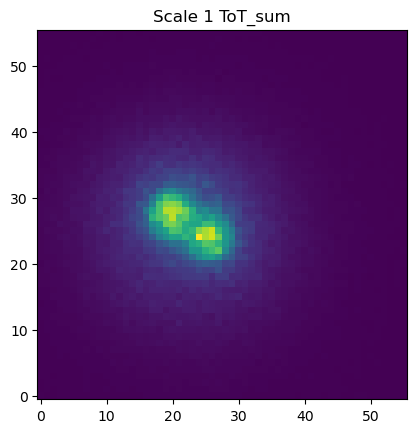

In [29]:
slice2d_noscatt=(slice(100,156), slice(100,156))

plt.figure(); plt.imshow(scale1_canvas_1[slice2d_noscatt], origin="lower"); plt.title("Scale 1 count 1")
plt.figure(); plt.imshow(scale1_canvas_ToT_max[slice2d_noscatt], origin="lower"); plt.title("Scale 1 ToT_max")
plt.figure(); plt.imshow(scale1_canvas_ToT_sum[slice2d_noscatt], origin="lower"); plt.title("Scale 1 ToT_sum")

<Figure size 640x480 with 0 Axes>

Text(0.5, 1.0, 'Scale 2 count 1')

<Figure size 640x480 with 0 Axes>

Text(0.5, 1.0, 'Scale 2 ToT_max')

<Figure size 640x480 with 0 Axes>

Text(0.5, 1.0, 'Scale 2 ToT_sum')

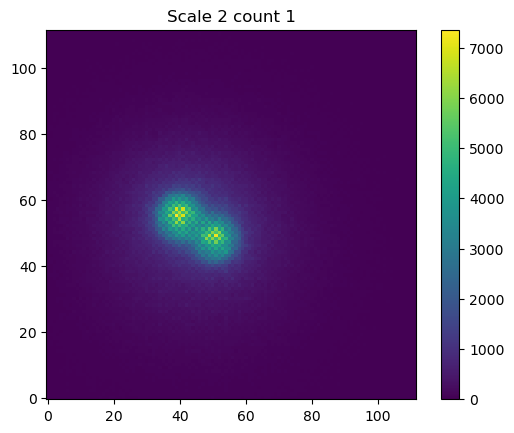

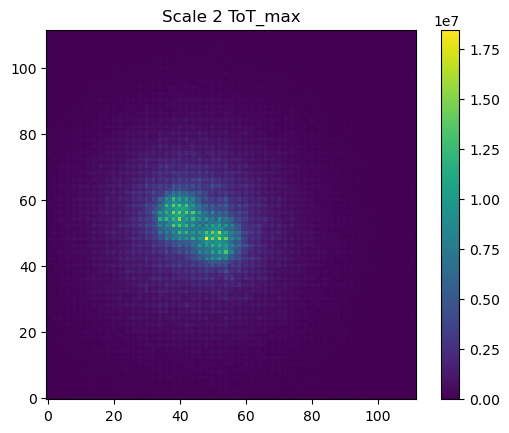

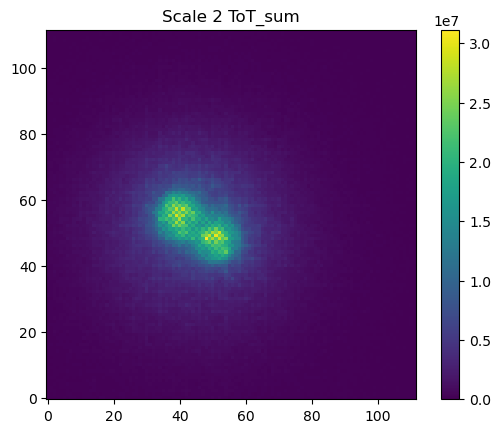

In [28]:
cent_df=cent_big.copy()
cent_df=cent_df[cent_df['n']>2]
scale2_canvas_1 = centroid_to_canvas(cent_df, scale=2, weight="1")
scale2_canvas_ToT_max = centroid_to_canvas(cent_df, scale=2, weight="ToT_max")
scale2_canvas_ToT_sum = centroid_to_canvas(cent_df, scale=2, weight="ToT_sum")

slice2d_noscatt_scale2=(slice(200,312), slice(200,312))

plt.figure(); plt.imshow(scale2_canvas_1[slice2d_noscatt_scale2], origin="lower"); plt.title("Scale 2 count 1"); plt.colorbar()
plt.figure(); plt.imshow(scale2_canvas_ToT_max[slice2d_noscatt_scale2], origin="lower"); plt.title("Scale 2 ToT_max"); plt.colorbar()
plt.figure(); plt.imshow(scale2_canvas_ToT_sum[slice2d_noscatt_scale2], origin="lower"); plt.title("Scale 2 ToT_sum"); plt.colorbar()

In [11]:
def centroid_to_canvas_subpixel(
		df: pd.DataFrame,
		scale: int = 1,
		x_col: str = "xc",
		y_col: str = "yc",
		weight: str = "count",
		canvas: np.ndarray | None = None,
		offset_x: float = 0.0,
		offset_y: float = 0.0,
		chunk_size=500_000,
):
	"""
	Distribute each centroid over up to 4 pixels using bilinear (area) weights so
	that the total intensity contributed by a centroid equals its weight.

	For centroid with scaled coordinate (x_s, y_s):
	  floor/ceil in x,y -> up to 4 pixels
	  fx = frac(x_s), fy = frac(y_s)
	  Weights: (1-fx)*(1-fy), fx*(1-fy), (1-fx)*fy, fx*fy

	Parameters
	----------
	df : DataFrame with centroid positions.
	scale : linear scale (1 => 256x256).
	weight : 'count' or column name.
	renormalize : if some pixels fall outside canvas, remaining weights are rescaled to preserve total.
	"""
	if scale < 1:
		raise ValueError("scale must be >=1")
	size = 256 * scale

	size_scaled=256*scale

	canvas = np.zeros((size_scaled, size_scaled), dtype=np.float64)
	n_total = len(df)

	for start in tqdm(
	  range(0, n_total, chunk_size),
	  total=(n_total + chunk_size - 1) // chunk_size,
	  desc="Aggregating",
	  unit="rows",
	):
	  end = min(start + chunk_size, n_total)
	  df_chunk = df.iloc[start:end]

	  x = (df_chunk[x_col].to_numpy(dtype=np.float64) + offset_x) * scale
	  y = (df_chunk[y_col].to_numpy(dtype=np.float64) + offset_y) * scale

	  if weight == "count":
	      base_w = np.ones(x.size, dtype=np.float64)
	  else:
	      if weight not in df_chunk.columns:
	          raise ValueError(f"weight column '{weight}' not found")
	      base_w = df_chunk[weight].to_numpy(dtype=np.float64)

	  floor_x = np.floor(x)
	  floor_y = np.floor(y)
	  mx = x - floor_x
	  my = y - floor_y

	  x1 = floor_x.astype(np.int32)
	  y1 = floor_y.astype(np.int32)
	  x2 = x1 + 1
	  y2 = y1 + 1

	  # Clamp to canvas bounds
	  x1 = np.clip(x1, 0, size_scaled - 1)
	  y1 = np.clip(y1, 0, size_scaled - 1)
	  x2 = np.clip(x2, 0, size_scaled - 1)
	  y2 = np.clip(y2, 0, size_scaled - 1)

	  w11 = (1 - mx) * (1 - my) * base_w
	  w12 = (1 - mx) * my * base_w
	  w21 = mx * (1 - my) * base_w
	  w22 = mx * my * base_w

	  cx = np.concatenate([x1, x1, x2, x2])
	  cy = np.concatenate([y1, y2, y1, y2])
	  w = np.concatenate([w11, w12, w21, w22])

	  np.add.at(canvas, (cy, cx), w)

	return canvas


In [18]:
cent_big.info()

<class 'pandas.core.frame.DataFrame'>
Index: 105464390 entries, 84739299 to 105464389
Data columns (total 9 columns):
 #   Column   Dtype  
---  ------   -----  
 0   t        uint64 
 1   xc       float32
 2   yc       float32
 3   ToT_max  uint32 
 4   ToT_sum  uint32 
 5   n        uint8  
 6   x        uint16 
 7   y        uint16 
 8   t_ns     float64
dtypes: float32(2), float64(1), uint16(2), uint32(2), uint64(1), uint8(1)
memory usage: 4.4 GB


In [16]:
canvas=centroid_to_canvas_subpixel(df=cent_big[cent_big['n']>2],scale=1,x_col="xc",y_col="yc",weight="count")

Aggregating:   0%|          | 0/195 [00:00<?, ?rows/s]

<Figure size 640x480 with 0 Axes>

Text(0.5, 1.0, 'n=')

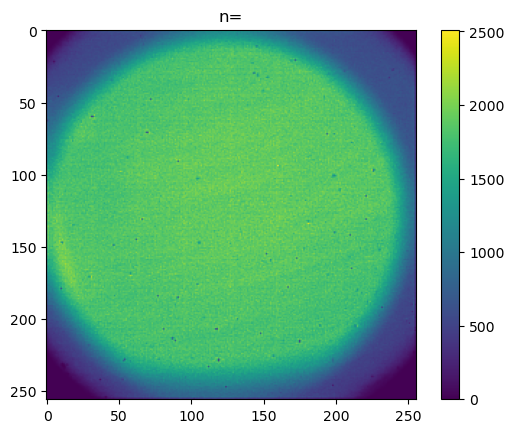

In [17]:
# assume `cent_big` and functions `centroid_to_canvas` and `centroid_to_canvas_subpixel` are available
scale = 1
x_slice_min, x_slice_max = 100, 156
y_slice_min, y_slice_max = 100, 156
x_slice_min_sc, x_slice_max_sc = x_slice_min * scale, x_slice_max * scale
y_slice_min_sc, y_slice_max_sc = y_slice_min * scale, y_slice_max * scale
slice2d = (slice(x_slice_min_sc, x_slice_max_sc),slice(y_slice_min_sc, y_slice_max_sc))
plt.figure()
plt.imshow(canvas)
plt.title(f"n="); plt.colorbar()
plt.show()

<Figure size 640x480 with 0 Axes>

Text(0.5, 1.0, 'n=1, val_col=ToT_sum')

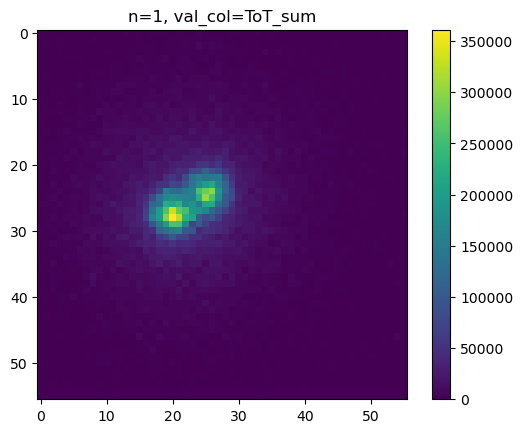

<Figure size 640x480 with 0 Axes>

Text(0.5, 1.0, 'n=2, val_col=ToT_sum')

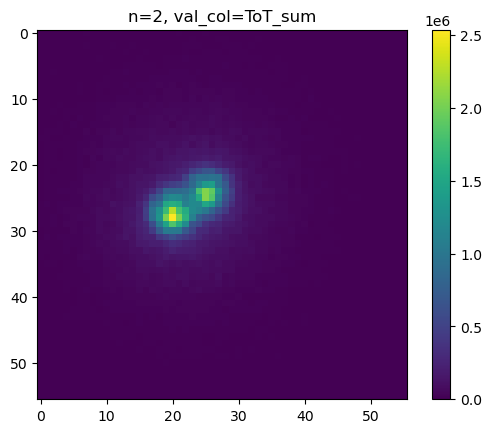

<Figure size 640x480 with 0 Axes>

Text(0.5, 1.0, 'n=3, val_col=ToT_sum')

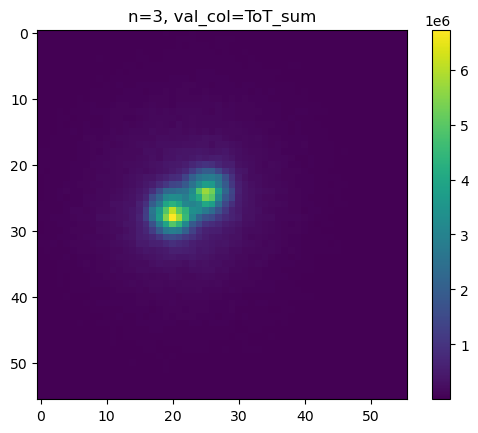

<Figure size 640x480 with 0 Axes>

Text(0.5, 1.0, 'n=4, val_col=ToT_sum')

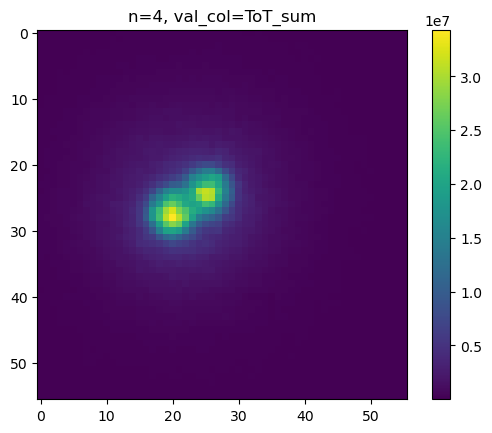

In [74]:
df_raw=cent_big.copy()
df_raw['1']=1

for nx in np.arange(1,5):
	df=df_raw[df_raw['n']==nx]
	x_col='xc'
	y_col='yc'
	val_col='ToT_sum'
	offset_x=0.0
	offset_y=0.0
	scale=1
	size=256

	size_scaled=size*scale

	x = (df[x_col].to_numpy(dtype=np.float64) + offset_x) * scale
	y = (df[y_col].to_numpy(dtype=np.float64) + offset_y) * scale

	n = x.size
	base_w = df[val_col]


	floor_x = np.floor(x)
	floor_y = np.floor(y)
	mx= x-floor_x
	my= y-floor_y
	# If fractional part is 0 exactly, we keep single pixel
	x1=floor_x.astype(np.int32)
	x2=x1+1
	y1=floor_y.astype(np.int32)
	y2=y1+1
	x2[x2>=size_scaled]=size_scaled-1
	y2[y2>=size_scaled]=size_scaled-1
	w11=(1 - mx) * (1 - my)*base_w
	w12=(1 - mx) * my*base_w
	w21=mx * (1 - my)*base_w
	w22=mx * my*base_w

	cx = np.concatenate([x1, x1, x2, x2])
	cy = np.concatenate([y1, y2, y1, y2])
	w  = np.concatenate([w11, w12, w21, w22])

	idx = np.repeat(np.arange(n), 4)

	canvas=np.zeros((size_scaled, size_scaled), dtype=np.float64)


	np.add.at(canvas, (cy, cx), w)

	plt.figure()
	plt.imshow(canvas[slice2d_noscatt])
	plt.title(f"n={nx}, val_col={val_col}"); plt.colorbar()
	plt.show()

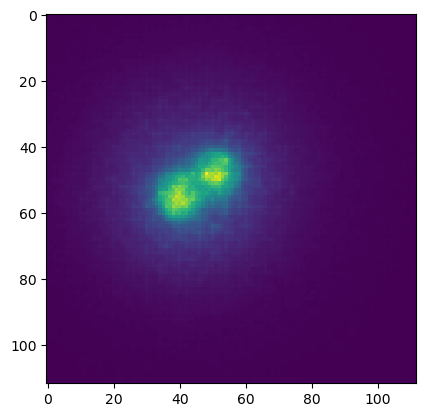

In [62]:
canvas

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], shape=(512, 512))

In [44]:
mantisxc=cent_big['xc']-np.floor(cent_big['xc'])

<Axes: >

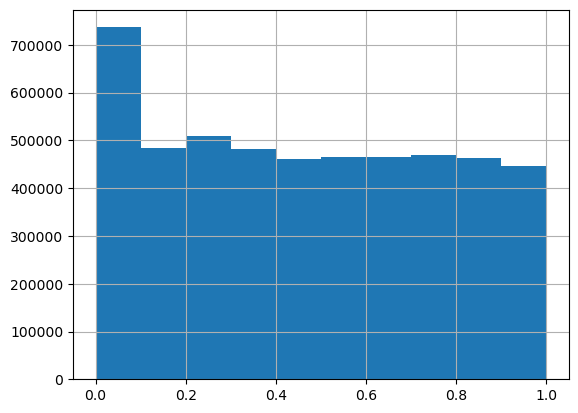

In [45]:
mantisxc.hist()

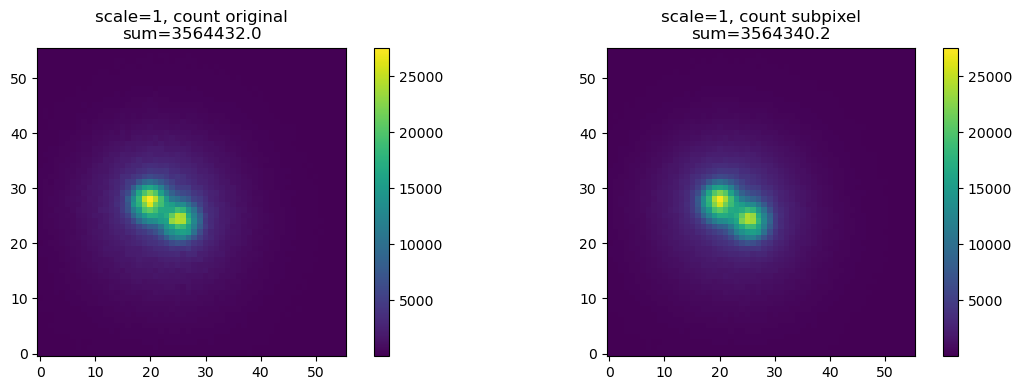

scale=1, count {'mse': np.float64(3555.263102505384), 'sum_orig': np.float64(3564432.0), 'sum_sub': np.float64(3564340.2313394547), 'max_orig': np.float64(27535.0), 'max_sub': np.float64(27136.474609375), 'corr': np.float64(0.9997890884972699)}


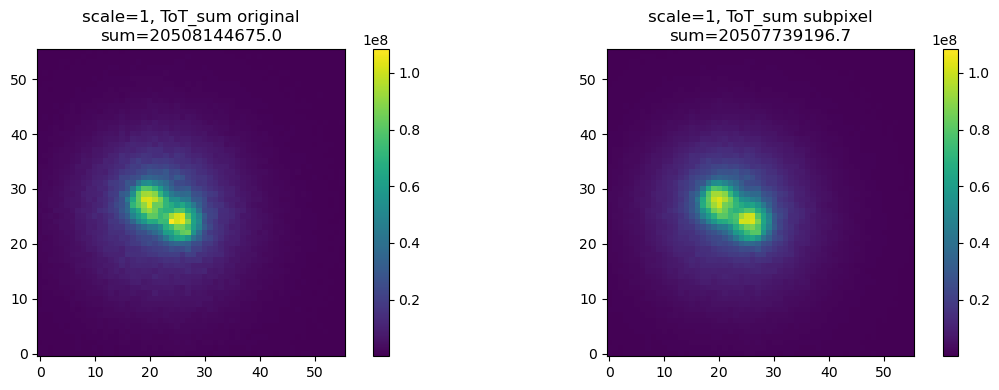

scale=1, ToT_sum {'mse': np.float64(119889888217.26582), 'sum_orig': np.float64(20508144675.0), 'sum_sub': np.float64(20507739196.703125), 'max_orig': np.float64(108478375.0), 'max_sub': np.float64(102635168.0), 'corr': np.float64(0.9996774081715656)}


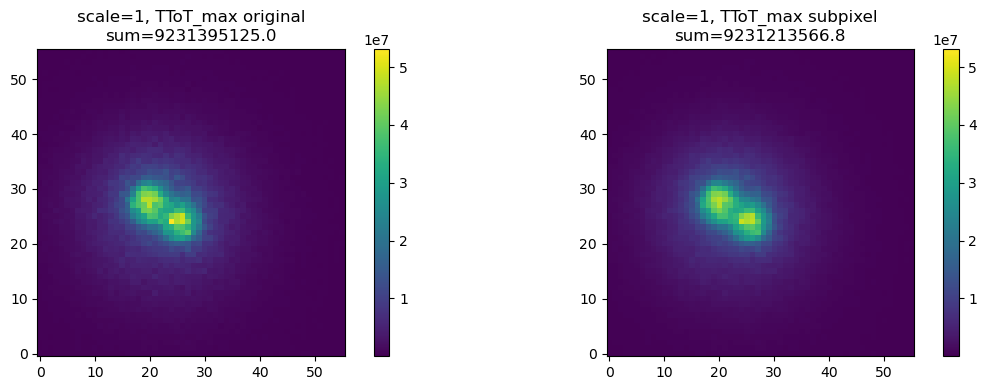

scale=1, TToT_max {'mse': np.float64(41305399519.72528), 'sum_orig': np.float64(9231395125.0), 'sum_sub': np.float64(9231213566.804688), 'max_orig': np.float64(53141525.0), 'max_sub': np.float64(48794260.0), 'corr': np.float64(0.9994712240535905)}


In [39]:
# assume `cent_big` and functions `centroid_to_canvas` and `centroid_to_canvas_subpixel` are available
scale = 1
x_slice_min, x_slice_max = 100, 156
y_slice_min, y_slice_max = 100, 156
x_slice_min_sc, x_slice_max_sc = x_slice_min * scale, x_slice_max * scale
y_slice_min_sc, y_slice_max_sc = y_slice_min * scale, y_slice_max * scale
slice2d = (slice(x_slice_min_sc, x_slice_max_sc),slice(y_slice_min_sc, y_slice_max_sc))

# build nearest-pixel canvases (existing function)
orig_count = centroid_to_canvas(cent_big, scale=scale, weight="1")
orig_tot_sum = centroid_to_canvas(cent_big, scale=scale, weight="ToT_sum")
orig_tot_max = centroid_to_canvas(cent_big, scale=scale, weight="ToT_max")

# build subpixel (area-weighted) canvases
sub_count = centroid_to_canvas_subpixel(cent_big, scale=scale, weight="1")
sub_tot_sum = centroid_to_canvas_subpixel(cent_big, scale=scale, weight="ToT_sum")
sub_tot_max = centroid_to_canvas_subpixel(cent_big, scale=scale, weight="ToT_max")

def metrics(a, b):
    a_s = a.astype(np.float64)
    b_s = b.astype(np.float64)
    mse = np.mean((a_s - b_s)**2)
    sum_a = a_s.sum()
    sum_b = b_s.sum()
    max_a = a_s.max()
    max_b = b_s.max()
    # correlation (guard against constant arrays)
    try:
        corr = np.corrcoef(a_s.ravel(), b_s.ravel())[0,1]
    except Exception:
        corr = np.nan
    return {"mse": mse, "sum_orig": sum_a, "sum_sub": sum_b, "max_orig": max_a, "max_sub": max_b, "corr": corr}

def show_compare(orig, sub, slice2d, name):
    a = orig[slice2d]
    b = sub[slice2d]
    diff = b - a
    m = metrics(a, b)
    vmin = min(a.min(), b.min())
    vmax = max(a.max(), b.max())
    fig, axs = plt.subplots(1, 2, figsize=(12, 4))
    im0 = axs[0].imshow(a, origin="lower", vmin=vmin, vmax=vmax)
    axs[0].set_title(f"{name} original\nsum={m['sum_orig']:.1f}")
    plt.colorbar(im0, ax=axs[0], fraction=0.046)
    im1 = axs[1].imshow(b, origin="lower", vmin=vmin, vmax=vmax)
    axs[1].set_title(f"{name} subpixel\nsum={m['sum_sub']:.1f}")
    plt.colorbar(im1, ax=axs[1], fraction=0.046)
    # im2 = axs[2].imshow(diff, origin="lower", cmap="RdBu_r")
    # axs[2].set_title(f"diff (sub - orig)\nMSE={m['mse']:.3f} corr={m['corr']:.3f}")
    # plt.colorbar(im2, ax=axs[2], fraction=0.046)
    # plt.suptitle(f"Comparison: {name} (scale={scale})")
    plt.tight_layout()
    plt.show()
    print(name, m)

# Run comparisons for the three weights
show_compare(orig_count, sub_count,slice2d,  f"scale={scale}, count")
show_compare(orig_tot_sum, sub_tot_sum,slice2d, f"scale={scale}, ToT_sum")
show_compare(orig_tot_max, sub_tot_max,slice2d, f"scale={scale}, TToT_max")

In [35]:
cent_df=cent_big.copy()

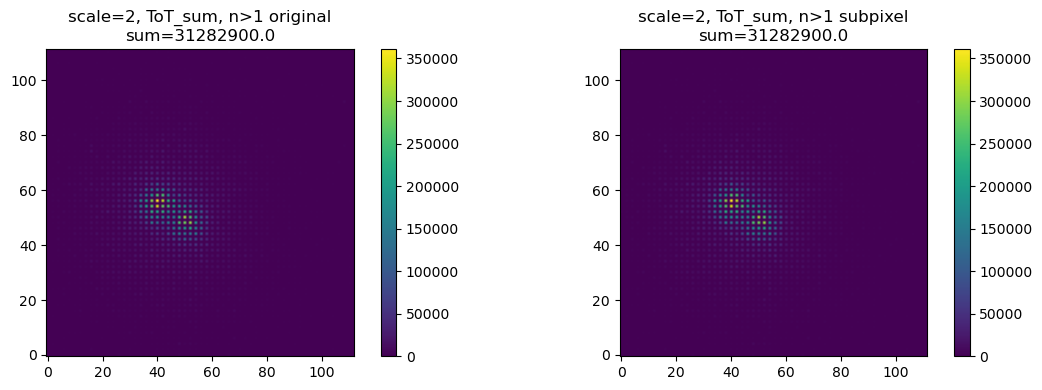

scale=2, ToT_sum, n>1 {'mse': np.float64(0.0), 'sum_orig': np.float64(31282900.0), 'sum_sub': np.float64(31282900.0), 'max_orig': np.float64(361225.0), 'max_sub': np.float64(361225.0), 'corr': np.float64(1.0)}


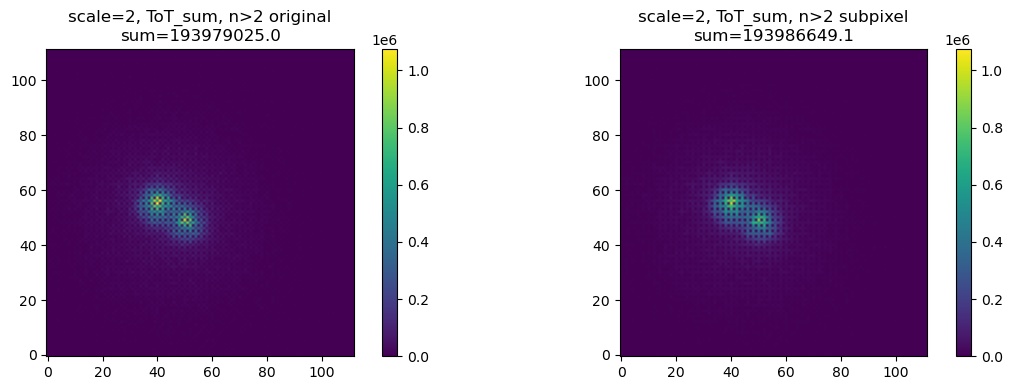

scale=2, ToT_sum, n>2 {'mse': np.float64(153843540.81557485), 'sum_orig': np.float64(193979025.0), 'sum_sub': np.float64(193986649.06339002), 'max_orig': np.float64(1075275.0), 'max_sub': np.float64(966828.125), 'corr': np.float64(0.9792310905690067)}


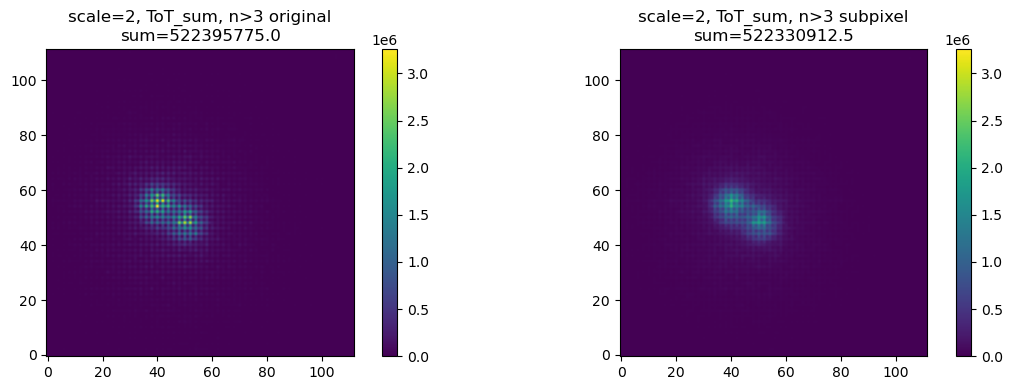

scale=2, ToT_sum, n>3 {'mse': np.float64(3122237210.636375), 'sum_orig': np.float64(522395775.0), 'sum_sub': np.float64(522330912.52632904), 'max_orig': np.float64(3259750.0), 'max_sub': np.float64(2233803.75), 'corr': np.float64(0.9464276692478031)}


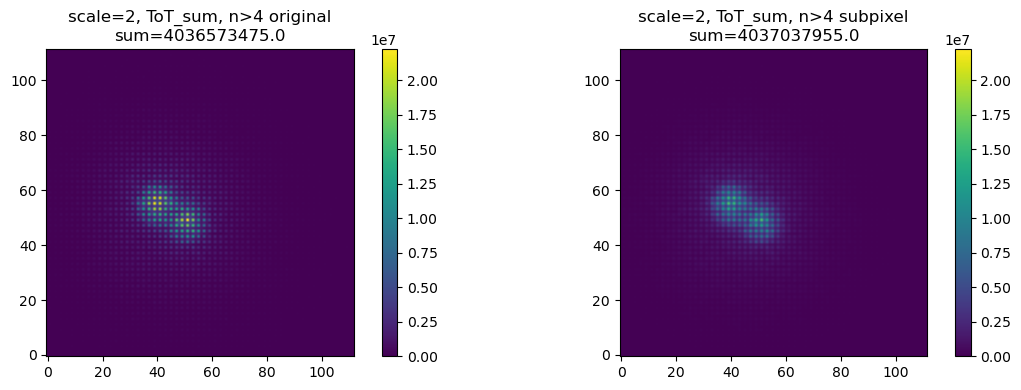

scale=2, ToT_sum, n>4 {'mse': np.float64(172149631619.08374), 'sum_orig': np.float64(4036573475.0), 'sum_sub': np.float64(4037037954.981056), 'max_orig': np.float64(22254575.0), 'max_sub': np.float64(15717556.0), 'corr': np.float64(0.9521936716930278)}


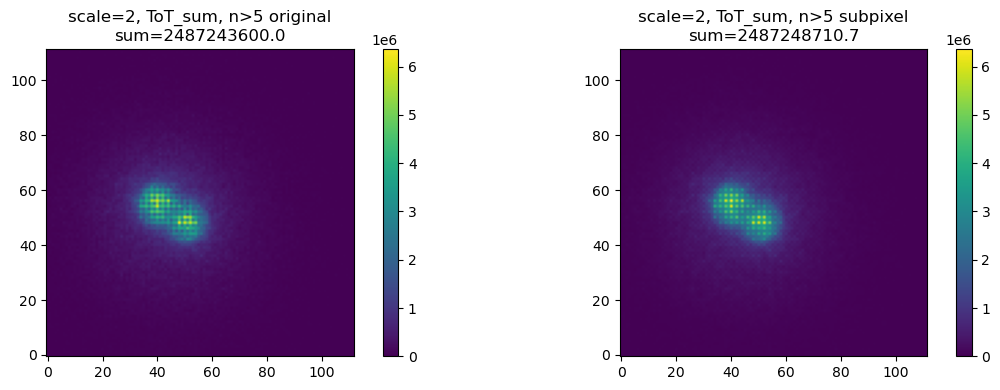

scale=2, ToT_sum, n>5 {'mse': np.float64(5532526119.537518), 'sum_orig': np.float64(2487243600.0), 'sum_sub': np.float64(2487248710.657362), 'max_orig': np.float64(6228675.0), 'max_sub': np.float64(6368380.0), 'corr': np.float64(0.9899355307086396)}


In [42]:
# assume `cent_big` and functions `centroid_to_canvas` and `centroid_to_canvas_subpixel` are available
scale = 2
x_slice_min, x_slice_max = 100, 156
y_slice_min, y_slice_max = 100, 156
x_slice_min_sc, x_slice_max_sc = x_slice_min * scale, x_slice_max * scale
y_slice_min_sc, y_slice_max_sc = y_slice_min * scale, y_slice_max * scale
slice2d = (slice(x_slice_min_sc, x_slice_max_sc),slice(y_slice_min_sc, y_slice_max_sc))



for nx in np.arange(1,6):
	cent_df_i=cent_df[cent_df['n']==nx]
	orig_tot_sum = centroid_to_canvas(cent_df_i, scale=scale, weight="ToT_sum")
	sub_tot_sum = centroid_to_canvas_subpixel(cent_df_i, scale=scale, weight="ToT_sum")
	show_compare(orig_tot_sum, sub_tot_sum,slice2d, f"scale={scale}, ToT_sum, n>{nx}")



(array([1.302960e+05, 2.714080e+05, 3.645780e+05, 1.388564e+06,
        6.596400e+05, 8.548170e+05, 6.348580e+05, 3.006700e+05,
        1.718340e+05, 8.079200e+04, 4.636800e+04, 2.956000e+04,
        1.809800e+04, 1.134200e+04, 6.936000e+03, 4.293000e+03,
        2.752000e+03, 1.926000e+03, 1.268000e+03, 8.730000e+02,
        6.630000e+02, 4.940000e+02, 3.880000e+02, 3.040000e+02,
        2.200000e+02, 1.690000e+02, 1.120000e+02, 4.800000e+01,
        8.000000e+00]),
 array([ 1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12., 13.,
        14., 15., 16., 17., 18., 19., 20., 21., 22., 23., 24., 25., 26.,
        27., 28., 29., 30.]),
 <BarContainer object of 29 artists>)

Text(0.5, 0, 'Cluster size (n)')

Text(0, 0.5, 'Count')

Text(0.5, 1.0, 'Distribution of cluster size `n`')

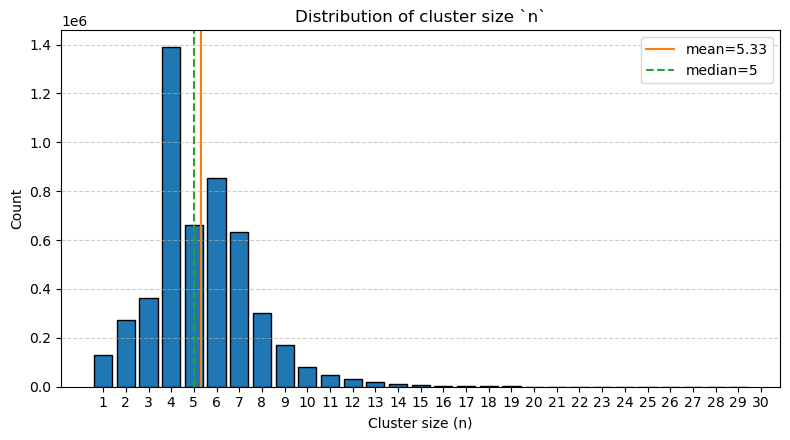

In [40]:
s = cent_big['n']

fig, ax = plt.subplots(figsize=(8, 4.5))
# integer bins (one bin per integer value)
bins = range(int(s.min()), int(s.max()) + 2)
ax.hist(s, bins=bins, align='left', rwidth=0.8, color='C0', edgecolor='black')

# labels, title, grid
ax.set_xlabel("Cluster size (n)")
ax.set_ylabel("Count")
ax.set_title("Distribution of cluster size `n`")
ax.grid(axis='y', linestyle='--', alpha=0.6)

# integer x ticks and show mean/median
ax.set_xticks(list(bins))
mean_val = s.mean()
median_val = s.median()
ax.axvline(mean_val, color='C1', linestyle='-', linewidth=1.5, label=f"mean={mean_val:.2f}")
ax.axvline(median_val, color='C2', linestyle='--', linewidth=1.5, label=f"median={median_val:.0f}")
ax.legend()

plt.tight_layout()
plt.show()